In [1]:
#import the required packages
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # These are functions from scikit-learn, also known as sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csc_matrix
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.models.keyedvectors as word2vec
from sentence_transformers import SentenceTransformer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef, average_precision_score, roc_auc_score
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import nltk
import matplotlib.pyplot as plt
import collections
from collections import Counter
from itertools import chain
from wordcloud import WordCloud

In [2]:
# Download additional NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/spulaparthy1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spulaparthy1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
#read the csv 
disney_df = pd.read_csv('DisneylandReviews.csv', encoding='latin-1')

In [36]:
disney_df.head(3)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong


## Text Preparation and Exploration

In [32]:
# Drop rows with missing values; reset index 
disney_df = disney_df.dropna().reset_index(drop=True)

In [37]:
# Some simple visualizations: number of reviews per branch
per_branch = pd.DataFrame(disney_df['Branch'].value_counts())
per_branch.reset_index(inplace=True)
per_branch.columns = ["Branch", "count"]
per_branch = per_branch.sort_values(by=['Branch'])
per_branch

,Branch,count
0,Disneyland_California,19406
2,Disneyland_HongKong,9620
1,Disneyland_Paris,13630


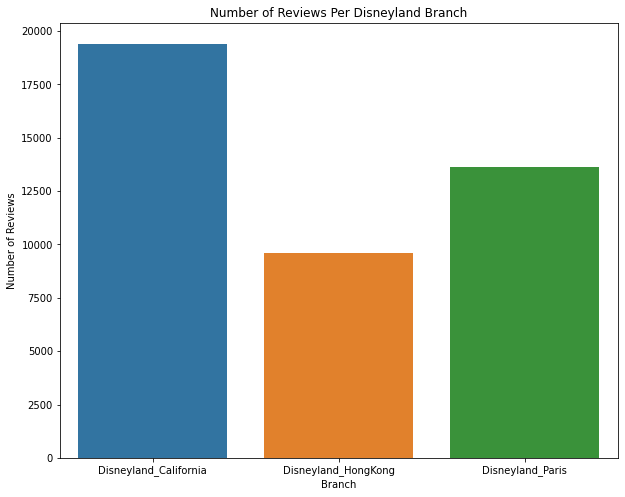

In [41]:
# Generate bar plot
plt.figure(figsize=(10,8))

sns.barplot(y='count', x='Branch', data = per_branch)
plt.title("Number of Reviews Per Disneyland Branch")
plt.xlabel("Branch")
plt.ylabel("Number of Reviews")
plt.show()

In [6]:
# Clean the text by removing punctuation, stopwords, digits
re_tokenizer = RegexpTokenizer("[\\w']+")
punc = string.punctuation 
digits = string.digits 
stopwords_nltk = set(nltk.corpus.stopwords.words('english'))

disney_df['reviews_cleaned'] = disney_df['review_text'].apply(re_tokenizer.tokenize)
disney_df['reviews_cleaned'] = disney_df['reviews_cleaned'].apply(lambda x: [word.lower() for word in x])
disney_df['reviews_cleaned'] = disney_df['reviews_cleaned'].apply(lambda x: [word for word in x if word not in punc])
disney_df['reviews_cleaned'] = disney_df['reviews_cleaned'].apply(lambda x: [word for word in x if word not in digits])
disney_df['reviews_cleaned'] = disney_df['reviews_cleaned'].apply(lambda x: [word for word in x if word not in stopwords_nltk])
disney_df.head(2)

,review_id,rating,rating_binary,year_month,reviewer_location,review_text,branch,reviews_cleaned
0,666542833,5,1,2019-1,United States,Love this place very clean and safe have it ow...,Disneyland_HongKong,"[love, place, clean, safe, mrt, get, night, ti..."
1,666297074,5,1,2019-1,India,I would recommend to go through below tips to ...,Disneyland_HongKong,"[would, recommend, go, tips, navigate, easily,..."


In [7]:
# Exploring tokens
tokens_list = disney_df['reviews_cleaned'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(50) # Look at the most frequent

,token,count
20,park,680
123,rides,590
144,disney,588
65,disneyland,515
127,day,481
7,time,464
5,get,321
72,great,290
163,one,286
13,go,258


In [8]:
# Token counts
total_tokens = len(tokens)
unique_tokens = len(unique_freq_df.index) 

print("Total tokens: {}".format(total_tokens))
print("Unique tokens: {}".format(unique_tokens))

count_sum = unique_freq_df['count'].sum()

Total tokens: 41668
Unique tokens: 5517


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

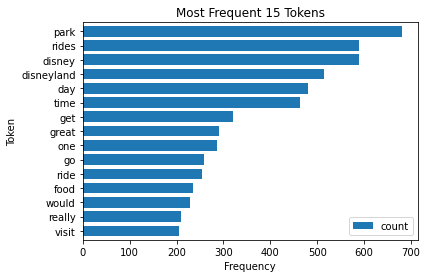

In [9]:
# Visualize most frequent words: frequency diagram
barh_plot = unique_freq_df.head(15).plot.barh(x = 'token', y = 'count',  width = 0.75, title = 'Most Frequent 15 Tokens') 
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

In [10]:
# Save to file 
barh_plot.figure.savefig('barh_plot.png')

# Convert to list
lemma_list = str(disney_df['reviews_cleaned'].tolist())

# Two methods for creating word clouds: from text or from table
# Here, from text.

def create_from_text_wordcloud(text, title):
    wordcloud = WordCloud(
        width = 750, 
        height = 500,
        max_words = 750, 
        background_color = 'white',
        collocations = False).generate(text)
    wordcloud.recolor(color_func = lambda *args, **kwargs: 'black')
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.savefig('wordcloud.png')
    plt.show()

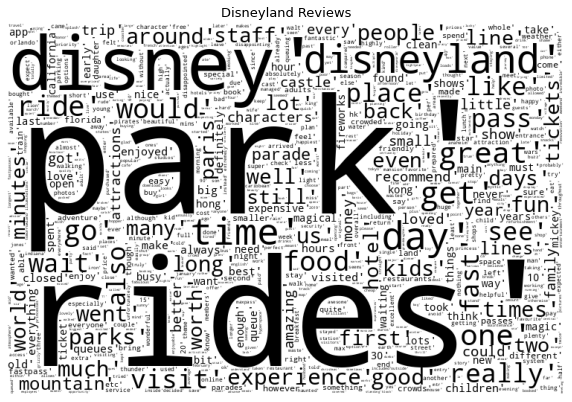

In [11]:
# Generate the word cloud
create_from_text_wordcloud(lemma_list, 'Disneyland Reviews')

In [12]:
#Detokenization and create the column reviews_cleaned
from nltk.tokenize.treebank import TreebankWordDetokenizer
disney_df['reviews_cleaned'] = disney_df['reviews_cleaned'].apply(lambda x: [TreebankWordDetokenizer().detokenize(x)]) # Detokenize
disney_df['reviews_cleaned'] = [','.join(map(str, l)) for l in disney_df['reviews_cleaned']] # Convert list to single string per row
disney_df.tail(2)

,review_id,rating,rating_binary,year_month,reviewer_location,review_text,branch,reviews_cleaned
682,670682799,4,1,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,since last time visit hk disneyland yet time s...
683,670565072,4,1,2019-5,Australia,All and all a great day was had. The crowds ar...,Disneyland_California,great day crowds huge ride times sometimes 50 ...


## Text representation and Model Building

In [13]:
# Set up training and test sets to 80% training and 20% testing

X_train, X_test, Y_train, Y_test = train_test_split(disney_df['review_text'], 
                                                    disney_df['rating_binary'],
                                                    test_size = 0.2,
                                                    stratify = disney_df['rating_binary']) # Stratify ensures equal distribution of 0/1 in training and test sets

In [14]:
#Bag-of-words count vectors x SVM

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # These are functions from scikit-learn, also known as sklearn

from sklearn.svm import LinearSVC

# Use sklearn's vectorizers: count vectors
cv_vec = CountVectorizer()
X_train_bow = cv_vec.fit_transform(X_train)
X_test_bow = cv_vec.transform(X_test)

# Train the SVM model
svm_model = LinearSVC()
svm_model.fit(X_train_bow, Y_train)

# Generate predictions on the test set
Y_pred_svm = svm_model.predict(X_test_bow)

# Add to performance_metrics dataframe
index = ['Precision', 'Recall', 'Accuracy', 'F1 score', 'MCC', 'AU PRC score', 'AU ROC score']
performance_metrics = pd.DataFrame([precision_score(Y_test, Y_pred_svm), 
                                    recall_score(Y_test, Y_pred_svm),
                                    accuracy_score(Y_test, Y_pred_svm),
                                    f1_score(Y_test, Y_pred_svm),
                                    matthews_corrcoef(Y_test, Y_pred_svm),
                                    average_precision_score(Y_test, Y_pred_svm),
                                    roc_auc_score(Y_test, Y_pred_svm)], index=index)


performance_metrics.columns = ['bow x SVM']
performance_metrics

,bow x SVM
Precision,0.935484
Recall,0.966667
Accuracy,0.912409
F1 score,0.950820
MCC,0.558063
AU PRC score,0.933498
AU ROC score,0.748039


In [15]:
#TF-IDF x SVM

# Create TF-IDF vectors
vectorizer = TfidfVectorizer() 
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the SVM model
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, Y_train)

# Generate predictions on the test set
Y_pred_svm = svm_model.predict(X_test_tfidf)

# Add to performance_metrics dataframe
index = ['Precision', 'Recall', 'Accuracy', 'F1 score', 'MCC', 'AU PRC score', 'AU ROC score']
svm_perf = pd.DataFrame([precision_score(Y_test, Y_pred_svm), 
                                    recall_score(Y_test, Y_pred_svm),
                                    accuracy_score(Y_test, Y_pred_svm),
                                    f1_score(Y_test, Y_pred_svm),
                                    matthews_corrcoef(Y_test, Y_pred_svm),
                                    average_precision_score(Y_test, Y_pred_svm),
                                    roc_auc_score(Y_test, Y_pred_svm)], index=index)



performance_metrics['TF-IDF x SVM'] = pd.Series(svm_perf[0])
performance_metrics


,bow x SVM,TF-IDF x SVM
Precision,0.935484,0.916031
Recall,0.966667,1.000000
Accuracy,0.912409,0.919708
F1 score,0.950820,0.956175
MCC,0.558063,0.568599
AU PRC score,0.933498,0.916031
AU ROC score,0.748039,0.676471


In [16]:
# TF-IDF x Naive Bayes

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf.toarray(), Y_train)

# Generate predictions on the test set
Y_pred_nb = nb_model.predict(X_test_tfidf.toarray())

# Add to performance_metrics dataframe
index = ['Precision', 'Recall', 'Accuracy', 'F1 score', 'MCC', 'AU PRC score', 'AU ROC score']
nb_perf = pd.DataFrame([precision_score(Y_test, Y_pred_nb), 
                                    recall_score(Y_test, Y_pred_nb),
                                    accuracy_score(Y_test, Y_pred_nb),
                                    f1_score(Y_test, Y_pred_nb),
                                    matthews_corrcoef(Y_test, Y_pred_nb),
                                    average_precision_score(Y_test, Y_pred_nb),
                                    roc_auc_score(Y_test, Y_pred_nb)], index=index)

performance_metrics['TF-IDF x NB'] = pd.Series(nb_perf[0])
performance_metrics

,bow x SVM,TF-IDF x SVM,TF-IDF x NB
Precision,0.935484,0.916031,0.875912
Recall,0.966667,1.000000,1.000000
Accuracy,0.912409,0.919708,0.875912
F1 score,0.950820,0.956175,0.933852
MCC,0.558063,0.568599,0.000000
AU PRC score,0.933498,0.916031,0.875912
AU ROC score,0.748039,0.676471,0.500000


In [17]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
# TF-IDF x XGBoost

import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_tfidf, Y_train)

# Generate predictions on the test set
Y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Add to performance_metrics dataframe
index = ['Precision', 'Recall', 'Accuracy', 'F1 score', 'MCC', 'AU PRC score', 'AU ROC score']
xgb_perf = pd.DataFrame([precision_score(Y_test, Y_pred_xgb), 
                                    recall_score(Y_test, Y_pred_xgb),
                                    accuracy_score(Y_test, Y_pred_xgb),
                                    f1_score(Y_test, Y_pred_xgb),
                                    matthews_corrcoef(Y_test, Y_pred_xgb),
                                    average_precision_score(Y_test, Y_pred_xgb),
                                    roc_auc_score(Y_test, Y_pred_xgb)], index=index)

performance_metrics['TF-IDF x XGB'] = pd.Series(xgb_perf[0])
performance_metrics

,bow x SVM,TF-IDF x SVM,TF-IDF x NB,TF-IDF x XGB
Precision,0.935484,0.916031,0.875912,0.929688
Recall,0.966667,1.000000,1.000000,0.991667
Accuracy,0.912409,0.919708,0.875912,0.927007
F1 score,0.950820,0.956175,0.933852,0.959677
MCC,0.558063,0.568599,0.000000,0.615135
AU PRC score,0.933498,0.916031,0.875912,0.929239
AU ROC score,0.748039,0.676471,0.500000,0.731127


In [19]:
#BERT x BERT

# Set up model and tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Use the same training and test splits as above
# Consolidate X and Y into single training dataframe; do the same for test
train = pd.concat([X_train, Y_train], axis=1).reset_index()
test = pd.concat([X_test, Y_test], axis=1).reset_index()

In [21]:
# Define two functions; first function:
# convert_data_to_examples converts each row of the train and test dataframes into an InputExample object

def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [22]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True)

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),),)

In [23]:
# Identify text and label columns
DATA_COLUMN = 'review_text'
LABEL_COLUMN = 'rating_binary'

In [24]:
# Call the functions created above to generate input sequences for the model
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]) # Can choose another measure if you like

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
36/36 [==============================] - 191s 5s/step - loss: 0.3594 - accuracy: 0.8784 - val_loss: 0.2259 - val_accuracy: 0.9124
Epoch 2/2
36/36 [==============================] - 165s 5s/step - loss: 0.0950 - accuracy: 0.9799 - val_loss: 0.1801 - val_accuracy: 0.9416


In [26]:
# Convert X_test into a list of strings
X_test_list = X_test.tolist()

In [27]:
# Apply the model to the test set 
tf_batch = tokenizer(X_test_list, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

labels = [0,1]
predicted_label = tf.argmax(tf_predictions, axis=1)
predicted_label = predicted_label.numpy()

In [28]:
# Set up Y_test as a numpy array to feed into sklearn's performance metric functions along with 'label'
Y_test_array = Y_test.to_numpy()

In [29]:
# Add to performance_metrics dataframe
index = ['Precision', 'Recall', 'Accuracy', 'F1 score', 'MCC', 'AU PRC score', 'AU ROC score']
bert_perf = pd.DataFrame([precision_score(Y_test_array, predicted_label), 
                                    recall_score(Y_test_array, predicted_label),
                                    accuracy_score(Y_test_array, predicted_label),
                                    f1_score(Y_test_array, predicted_label),
                                    matthews_corrcoef(Y_test_array, predicted_label),
                                    average_precision_score(Y_test_array, predicted_label),
                                    roc_auc_score(Y_test_array, predicted_label)], index=index)

performance_metrics['BERT x BERT'] = pd.Series(bert_perf[0])
performance_metrics

,bow x SVM,TF-IDF x SVM,TF-IDF x NB,TF-IDF x XGB,BERT x BERT
Precision,0.935484,0.916031,0.875912,0.929688,0.959016
Recall,0.966667,1.000000,1.000000,0.991667,0.975000
Accuracy,0.912409,0.919708,0.875912,0.927007,0.941606
F1 score,0.950820,0.956175,0.933852,0.959677,0.966942
MCC,0.558063,0.568599,0.000000,0.615135,0.718889
AU PRC score,0.933498,0.916031,0.875912,0.929239,0.956939
AU ROC score,0.748039,0.676471,0.500000,0.731127,0.840441


### Among all the models executed, the best model is BERT model followed by SVM with bag of words input and then XGBoost with tf-idf input